## Explain How SageMaker Calculate Bias Metric Pre-Training 
haimtran June 09 2023

- Hand calculate bias metrics: CI, DPL, KL, JS
- Compare with Wrangler Bias Report

In [106]:
import boto3
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sagemaker
from IPython.display import Markdown, display

## SageMaker Session

In [3]:
role = sagemaker.get_execution_role()

In [4]:
session = sagemaker.session.Session()

In [5]:
bucket = session.default_bucket()

## Upload Data to S3 for Wrangler 

In [32]:
local_file_path = "./../../data/bank-additional/bank-additional-full.csv"

In [30]:
s3_client = boto3.client("s3")

In [33]:
s3_client.upload_file(
    local_file_path,
    bucket,
    "bank/bank-additional-full.csv",
)

## Load Data 

In [6]:
pd.options.display.max_columns = 300

In [34]:
df = pd.read_csv(local_file_path)

In [8]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [9]:
df.dtypes

age                 int64
job                object
marital            object
education          object
default            object
housing            object
loan               object
contact            object
month              object
day_of_week        object
duration            int64
campaign            int64
pdays               int64
previous            int64
poutcome           object
emp.var.rate      float64
cons.price.idx    float64
cons.conf.idx     float64
euribor3m         float64
nr.employed       float64
y                  object
dtype: object

## Marital Comlumn - Feature 

In [16]:
marital = df.value_counts("marital")

In [17]:
marital

marital
married     24928
single      11568
divorced     4612
unknown        80
dtype: int64

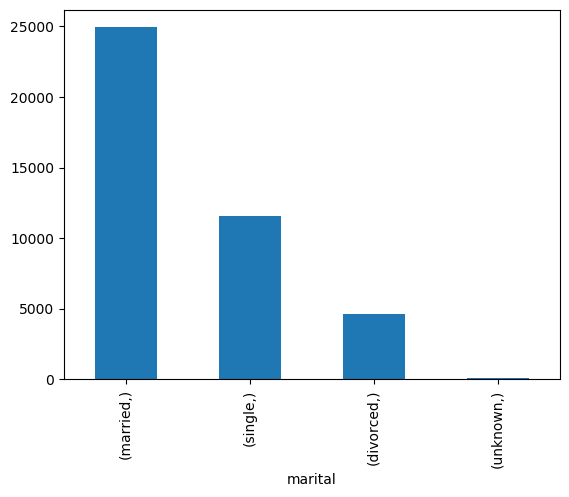

In [18]:
df.value_counts(["marital"]).plot.bar()
plt.show()

## Class Imbalance - CI

Here is the [docs](https://docs.aws.amazon.com/sagemaker/latest/dg/clarify-bias-metric-class-imbalance.html)

## $$ CI = \frac{n_a - n_d}{n_a + n_d}$$

- $n_a$ is the number of facet a ==> no. of maried 
- $n_d$ is the number of facet b ==> no. of no married 

In [24]:
n_a = len(df[df["marital"] == "married"])

In [25]:
n_b = len(df[df["marital"] != "married"])

In [26]:
ci = (n_a - n_b) / (n_a + n_b)

In [80]:
# print(f"class imbalanced facet married: {ci}")

In [206]:
display(Markdown(f"### class imbalanced facet married: {ci:.10f}"))

### class imbalanced facet married: 0.2104496455

## Difference in Positive Proportions in Labels (DPL)

## $$ q_a = \frac{n_a^{(1)}}{n_a}, q_b = \frac{n_d^{(1)}}{n_d} $$
## $$ DPL = (q_a - q_b) $$

- $n_a^{(1)}$ is the number of facet a given positive label ==> no. married and y = 1
- $n_d^{(1)}$ is the number of facet d given positive label ==> no. not married and y = 1

In [65]:
n_a = len(df[df["marital"] == "married"])

In [66]:
n_a_1 = len(df[(df["marital"] == "married") & (df["y"] == "yes")])

In [67]:
n_d = len(df[df["marital"] != "married"])

In [68]:
n_d_1 = len(df[(df["marital"] != "married") & (df["y"] == "yes")])

In [69]:
q_a = n_a_1 / n_a

In [70]:
q_b = n_d_1 / n_d

In [71]:
dpl = q_a - q_b

In [85]:
# dpl

In [207]:
display(Markdown(f"### Difference in Positive Proportions in Labels: {dpl:.10f}"))

### Difference in Positive Proportions in Labels: -0.0280707675

## Kullback-Leibler Divergence (KL)

## $$ KL = \sum_y P_a(y)log{\frac{P_a(y)}{P_d(y)}}$$

In [155]:
p_positive_given_a = len(df[(df["marital"] == "married") & (df["y"] == "yes")]) / n_a

In [156]:
p_positive_given_d = len(df[(df["marital"] != "married") & (df["y"] == "yes")]) / n_d

In [157]:
p_negative_given_a = len(df[(df["marital"] == "married") & (df["y"] == "no")]) / n_a

In [158]:
p_negative_given_d = len(df[(df["marital"] != "married") & (df["y"] == "no")]) / n_d

In [210]:
kl = p_positive_given_a * np.log(p_positive_given_a / p_positive_given_d)+p_negative_given_a * np.log(p_negative_given_a / p_negative_given_d)

In [211]:
display(Markdown(f"### KL Divergence: {kl:.10f}"))

### KL Divergence: 0.0037335598

## Jessen Shannon

## $$ JS = \frac{1}{2}[LK(P_a || P) + KL(P_d || P)]  $$

## $$ P = \frac{1}{2}(P_a + P_d)$$

In [221]:
p_positive_given_a = len(df[(df["marital"] == "married") & (df["y"] == "yes")]) / n_a

In [222]:
p_positive_given_d = len(df[(df["marital"] != "married") & (df["y"] == "yes")]) / n_d

In [223]:
p_negative_given_a = len(df[(df["marital"] == "married") & (df["y"] == "no")]) / n_a

In [224]:
p_negative_given_d = len(df[(df["marital"] != "married") & (df["y"] == "no")]) / n_d

In [225]:
p_positive = 0.5 * (p_positive_given_a + p_positive_given_d)

In [226]:
p_negative = 0.5 * (p_negative_given_a + p_negative_given_d)

In [227]:
item_1 = p_positive_given_a * np.log(p_positive_given_a / p_positive) + p_negative_given_a * np.log(p_negative_given_a / p_negative)

In [228]:
item_2 = p_positive_given_d * np.log(p_positive_given_d / p_positive) + p_negative_given_d * np.log(p_negative_given_d / p_negative)

In [229]:
js = 0.5*(item_1 + item_2)

In [230]:
display(Markdown(f"### Jessen Shannon Divergence: {js:.10f}"))

### Jessen Shannon Divergence: 0.0009654646